# *EECP0008 - INTELIGÊNCIA ARTIFICIAL (2022 .1 - T01)*

## *PROJETO FINAL*
*EQUIPE D: JEFFERSSON DE CARVALHO, JOAO GABRIEL MUNIZ DA SILVA, RANIERE MENDES DOS SANTOS, PEDRO HENRIQUE MODESTO DE AGUIAR E WELYAB DA SILVA PAULA.*

-----------------------------------------------------------
OBJETIVO: A partir da base de dados "in-vehicle coupon recommendation Data", implementaremos os seguintes métodos de aprendizado de máquina:
* Random Forest 
* KNN
* Árvore de Decisão
* SVM

Com o intuito de classificar um conjunto de teste (de forma supervisionada) que analisa qual, dos 5 tipos de cupom (**Bar, Restaurante Apenas p/ Retirada, Cafeteria, Restaurante Barato, Restaurante Caro)**, foi oferecido a ela durante o trânsito, baseado em condições como:

* **Aceitação: Cupom Aceito, Cupom não aceito**

* **destino: Local Não Urgente, Casa, Trabalho**

* **Passageiro: Sozinho, Amigo(s), Filho(s), Parceiro (que são os passageiros do carro)**

* **Clima: Ensolarado, Chuvoso, Nevado**

* **Temperatura: 55, 80, 30**

* **hora: 14h , 10h, 18h, 7h, 22h**

---------------------------------------------------------

Para isso, utilizaremos:
* Uma técnica de validação cruzada (Stratified KFold);
* Otimização dos parâmetros do algoritmo de aprendizagem de máquina;
* Métodos de Avaliação dos resultados.

-----------------------------------------------------------------
Referências:

* http://archive.ics.uci.edu/ml/datasets/in-vehicle+coupon+recommendation

* Wang, Tong, Cynthia Rudin, Finale Doshi-Velez, Yimin Liu, Erica Klampfl, and Perry MacNeille. 'A bayesian framework for learning rule sets for interpretable classification.' The Journal of Machine Learning Research 18, no. 1 (2017): 2357-2393.

# -> Importando Bibliotecas e Base de dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# para normalizar os dados
from sklearn.preprocessing import StandardScaler
# para reduzir a dimensionalidade
from sklearn.decomposition import PCA
# Construir pipeline
from sklearn.pipeline import make_pipeline
#Dividir dataset em dados de treino e teste
from sklearn.model_selection import train_test_split
#Exibir Métricas de Classofocação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#Algorítimo de Validação Cruzada
from sklearn.model_selection import StratifiedKFold
#Algoritimo de Balanceamento por UnderSampling
from imblearn.under_sampling import NearMiss
#Algoritimo de Balanceamento por OverSampling
from imblearn.over_sampling import SMOTE

In [ ]:
data_base = pd.read_csv("/content/in-vehicle-coupon-recommendation.csv")
data_base.info()

FileNotFoundError: ignored

# -> Pré-Processamento:

In [ ]:
data_base.isnull().sum() #Verificando a presença de campos nulos

In [ ]:
plt = sb.countplot(x="toCoupon_GEQ5min", data=data_base)

In [ ]:
plt = sb.countplot(x="car", data=data_base)

In [ ]:
data_base = data_base.drop('toCoupon_GEQ5min', axis=1) #A Feature "toCoupon_GEQ5min" possui apenas o valor 1
data_base = data_base.drop('car', axis=1) #A Feature possui grande quantidade de valores nulos
data_base.dropna(inplace = True) #excluindo linhas com valores nulos

In [ ]:
data_base.isnull().sum() #Verificando novamente a presença de campos nulos

In [ ]:
data_base.info()

Agora que todos os campos em branco foram removidos, os dados de algumas Features que se encontram textuais devem ser convertidos em dados numéricos:

In [ ]:
data_base["destination"] = data_base["destination"].map({"Home":0, "No Urgent Place":1, "Work":2})
data_base["passanger"] = data_base["passanger"].map({"Alone":0, "Friend(s)":1, "Kid(s)":2, "Partner":3})
data_base["weather"] = data_base["weather"].map({"Rainy":0, "Snowy":1, "Sunny":2})
data_base["time"] = data_base["time"].map({"7AM":7, "10AM":10, "2PM":14, "6PM":18, "10PM":22})
data_base["coupon"] = data_base["coupon"].map({"Bar":0, "Carry out & Take away":1, "Coffee House":2, 
                                               "Restaurant(<20)":3, "Restaurant(20-50)":4})
data_base["expiration"] = data_base["expiration"].map({"2h":0, "1d":1})
data_base["gender"] = data_base["gender"].map({"Female":0, "Male":1})
data_base["age"] = data_base["age"].map({"below21":0, "21":21, "26":26, "31":31, "36":36, "41":41, "46":46, "50plus":50})
data_base["maritalStatus"] = data_base["maritalStatus"].map({"Divorced":0, "Married partner":1, 
                                                             "Single":2, "Unmarried partner":3, "Widowed":4})
data_base["education"] = data_base["education"].map({"Associates degree":0, "Bachelors degree":1, 
                                                     "Graduate degree (Masters or Doctorate)":2, 
                                                     "High School Graduate":3, "Some college - no degree":4, 
                                                     "Some High School":5})
data_base["Bar"] = data_base["Bar"].map({"never":0, "less1":1, "1~3":2, "4~8":3, "gt8":4})
data_base["CoffeeHouse"] = data_base["CoffeeHouse"].map({"never":0, "less1":1, "1~3":2, "4~8":3, "gt8":4})
data_base["CarryAway"] = data_base["CarryAway"].map({"never":0, "less1":1, "1~3":2, "4~8":3, "gt8":4})
data_base["RestaurantLessThan20"] = data_base["RestaurantLessThan20"].map({"never":0, "less1":1, "1~3":2, "4~8":3, "gt8":4})
data_base["Restaurant20To50"] = data_base["Restaurant20To50"].map({"never":0, "less1":1, "1~3":2, "4~8":3, "gt8":4})
data_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12079 entries, 22 to 12683
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12079 non-null  int64 
 1   passanger             12079 non-null  int64 
 2   weather               12079 non-null  int64 
 3   temperature           12079 non-null  int64 
 4   time                  12079 non-null  int64 
 5   coupon                12079 non-null  int64 
 6   expiration            12079 non-null  int64 
 7   gender                12079 non-null  int64 
 8   age                   12079 non-null  int64 
 9   maritalStatus         12079 non-null  int64 
 10  has_children          12079 non-null  int64 
 11  education             12079 non-null  int64 
 12  occupation            12079 non-null  object
 13  income                12079 non-null  object
 14  Bar                   12079 non-null  int64 
 15  CoffeeHouse           12079 non-nul

Agora transformando as demais Features categóricas em quantitativas:

In [ ]:
data_base = pd.get_dummies(data_base,columns=['occupation','income'])

In [ ]:
data_base.shape

(12079, 56)

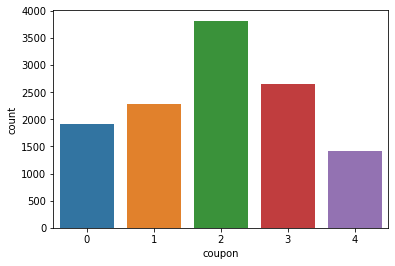

In [ ]:
plt = sb.countplot(x="coupon", data=data_base)
# "Bar"-> 0, "Carry out & Take away" ->1, "Coffee House" ->2, "Restaurant(<20)" -> 3, "Restaurant(20-50)"-> 4

\Balenceando as Classes com Undersampling utilizando NearMiss:

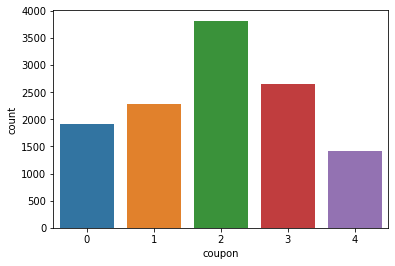

In [ ]:
plt = sb.countplot(x="coupon", data=data_base)

In [ ]:
nm = NearMiss()

In [ ]:
x_nm = data_base.drop("coupon", axis = 1)
y_nm = data_base.coupon

In [ ]:
x_nm, y_nm = nm.fit_resample(x_nm, y_nm)

In [ ]:
data_base_nm = x_nm.merge(y_nm,left_index=True, right_index=True)

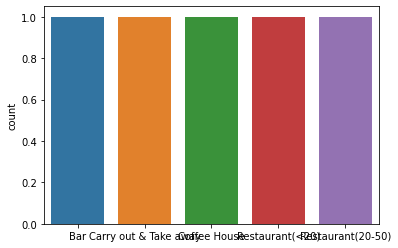

In [ ]:
plt = sb.countplot(x=["Bar", "Carry out & Take away", "Coffee House", "Restaurant(<20)" , "Restaurant(20-50)"], data = data_base_nm)

**Testando Acurácia do Modelo com UnderSampling**



In [ ]:
rf = RandomForestClassifier()
x = data_base_nm.drop("coupon", axis = 1)
y = data_base_nm.coupon
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 10, stratify = y)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.7545146726862303

In [ ]:
print(pd.crosstab(y_test, y_pred, rownames = ["Real"], colnames = ["Predito"], margins = True))

Predito    0    1    2    3    4   All
Real                                  
0        298    5   23   14   14   354
1         10  286   43   11    5   355
2          9   31  237   48   29   354
3          9   22   35  273   15   354
4         25   13   50   24  243   355
All      351  357  388  370  306  1772


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       354
           1       0.80      0.81      0.80       355
           2       0.61      0.67      0.64       354
           3       0.74      0.77      0.75       354
           4       0.79      0.68      0.74       355

    accuracy                           0.75      1772
   macro avg       0.76      0.75      0.76      1772
weighted avg       0.76      0.75      0.76      1772



**Balanceando as Classes com OverSampling utilizando SMOTE**

In [ ]:
plt = sb.countplot(x="coupon", data=data_base)

In [ ]:
smt = SMOTE()

In [ ]:
x_smt = data_base.drop("coupon", axis = 1)
y_smt = data_base.coupon

In [ ]:
x_smt, y_smt = smt.fit_resample(x_smt, y_smt)

In [ ]:
data_base_smt = x_smt.merge(y_smt,left_index=True, right_index=True)

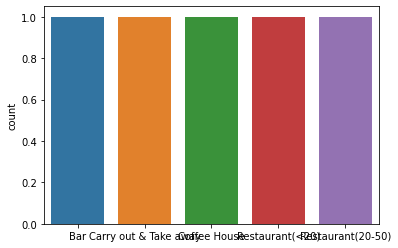

In [ ]:
plt = sb.countplot(x=["Bar", "Carry out & Take away", "Coffee House", "Restaurant(<20)" , "Restaurant(20-50)"], data=data_base_smt)

**Testando Acurácia do Modelo com OverSampling**

In [ ]:
rf = RandomForestClassifier()
x = data_base_smt.drop("coupon", axis = 1)
y = data_base_smt.coupon
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 10, stratify = y)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.8614255765199161

In [ ]:
print(pd.crosstab(y_test, y_pred, rownames = ["Real"], colnames = ["Predito"], margins = True))

Predito     0     1    2    3    4   All
Real                                    
0         900     5   15   14   20   954
1          10   874   34   21   15   954
2          44    86  712   79   33   954
3          29    53   59  786   27   954
4          37    19   37   24  837   954
All      1020  1037  857  924  932  4770


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       954
           1       0.84      0.92      0.88       954
           2       0.83      0.75      0.79       954
           3       0.85      0.82      0.84       954
           4       0.90      0.88      0.89       954

    accuracy                           0.86      4770
   macro avg       0.86      0.86      0.86      4770
weighted avg       0.86      0.86      0.86      4770



Atribuindo melhor modelo para teste:

In [ ]:
data_base = data_base_smt
data_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19080 entries, 0 to 19079
Data columns (total 56 columns):
 #   Column                                                Non-Null Count  Dtype
---  ------                                                --------------  -----
 0   destination                                           19080 non-null  int64
 1   passanger                                             19080 non-null  int64
 2   weather                                               19080 non-null  int64
 3   temperature                                           19080 non-null  int64
 4   time                                                  19080 non-null  int64
 5   expiration                                            19080 non-null  int64
 6   gender                                                19080 non-null  int64
 7   age                                                   19080 non-null  int64
 8   maritalStatus                                         19080 non-null  int64


In [ ]:
y = np.array(data_base["coupon"])
X = np.array(data_base.drop("coupon", axis=1))

# -> Dividindo treino x teste

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)

# -> Criando um pipeline com o modelo Random Forest e treinando

In [ ]:
rf_pl = make_pipeline(PCA(n_components=55),
                          RandomForestClassifier(n_estimators=100, criterion='gini', random_state=0))
rf_pl.fit(Xtrain, ytrain)

Pipeline(steps=[('pca', PCA(n_components=55)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

# -> Criando um pipeline com o modelo KNN e treinando

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_pl = make_pipeline(PCA(n_components=55),
                          KNeighborsClassifier(n_neighbors=8))
knn_pl.fit(Xtrain, ytrain)

Pipeline(steps=[('pca', PCA(n_components=55)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=8))])

# -> Criando um pipeline com o modelo Árvore de Decisão e treinando

In [ ]:
from sklearn.tree import DecisionTreeClassifier
ad_pl = make_pipeline(PCA(n_components=55),
                          DecisionTreeClassifier())
ad_pl.fit(Xtrain, ytrain)

Pipeline(steps=[('pca', PCA(n_components=55)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

# -> Criando um pipeline com o modelo SVM e treinando

In [ ]:
from sklearn.svm import SVC
svm_pl = make_pipeline(PCA(n_components=55),
                          SVC(kernel='rbf'))
svm_pl.fit(Xtrain, ytrain)

Pipeline(steps=[('pca', PCA(n_components=55)), ('svc', SVC())])

# -> Avaliando a capacidade de generalização dos modelos com a Validação Cruzada do tipo Stratified KFold

In [ ]:
'''Utilizamos a validação cruzada do tipo StratifiedKFold pois ela garante
que para cada fold teremos o balanceamento das classes.'''

Kfold = StratifiedKFold(n_splits=3).split(Xtrain, ytrain)
scores = []

for k, (train, test) in enumerate(Kfold):
  rf_pl.fit(Xtrain[train], ytrain[train])
  score = rf_pl.score(Xtrain[test], ytrain[test])
  scores.append(score)
  print('Fold: %2d, Distribuição da classe: %s, Acur.: %.3f' %(k+1, np.bincount(ytrain[test]), score))

Fold:  1, Distribuição da classe: [893 898 896 884 881], Acur.: 0.752
Fold:  2, Distribuição da classe: [893 898 895 885 881], Acur.: 0.766
Fold:  3, Distribuição da classe: [892 899 896 884 881], Acur.: 0.771


In [ ]:
print("Acurácia Média entre os Folds: ", np.mean(scores))

Acurácia Média entre os Folds:  0.7632524707996406


In [ ]:
Kfold = StratifiedKFold(n_splits=3).split(Xtrain, ytrain)
scores = []

for k, (train, test) in enumerate(Kfold):
  knn_pl.fit(Xtrain[train], ytrain[train])
  score = knn_pl.score(Xtrain[test], ytrain[test])
  scores.append(score)
  print('Fold: %2d, Distribuição da classe: %s, Acur.: %.3f' %(k+1, np.bincount(ytrain[test]), score))

Fold:  1, Distribuição da classe: [893 898 896 884 881], Acur.: 0.525
Fold:  2, Distribuição da classe: [893 898 895 885 881], Acur.: 0.537
Fold:  3, Distribuição da classe: [892 899 896 884 881], Acur.: 0.522


In [ ]:
print("Acurácia Média entre os Folds: ", np.mean(scores))

Acurácia Média entre os Folds:  0.52785265049416


In [ ]:
Kfold = StratifiedKFold(n_splits=3).split(Xtrain, ytrain)
scores = []

for k, (train, test) in enumerate(Kfold):
  ad_pl.fit(Xtrain[train], ytrain[train])
  score = ad_pl.score(Xtrain[test], ytrain[test])
  scores.append(score)
  print('Fold: %2d, Distribuição da classe: %s, Acur.: %.3f' %(k+1, np.bincount(ytrain[test]), score))

Fold:  1, Distribuição da classe: [893 898 896 884 881], Acur.: 0.700
Fold:  2, Distribuição da classe: [893 898 895 885 881], Acur.: 0.691
Fold:  3, Distribuição da classe: [892 899 896 884 881], Acur.: 0.728


In [ ]:
print("Acurácia Média entre os Folds: ", np.mean(scores))

Acurácia Média entre os Folds:  0.7060497154836778


In [ ]:
Kfold = StratifiedKFold(n_splits=3).split(Xtrain, ytrain)
scores = []

for k, (train, test) in enumerate(Kfold):
  svm_pl.fit(Xtrain[train], ytrain[train])
  score = svm_pl.score(Xtrain[test], ytrain[test])
  scores.append(score)
  print('Fold: %2d, Distribuição da classe: %s, Acur.: %.3f' %(k+1, np.bincount(ytrain[test]), score))

Fold:  1, Distribuição da classe: [893 898 896 884 881], Acur.: 0.446
Fold:  2, Distribuição da classe: [893 898 895 885 881], Acur.: 0.441
Fold:  3, Distribuição da classe: [892 899 896 884 881], Acur.: 0.448


In [ ]:
print("Acurácia Média entre os Folds: ", np.mean(scores))

Acurácia Média entre os Folds:  0.44496855345911945


# -> Testando os nossos Modelos com os dados de teste

In [ ]:
y_pred = rf_pl.predict(Xtest)
print(rf_pl.score(Xtest, ytest))

0.7679944095038435


In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1138
           1       0.78      0.81      0.79      1121
           2       0.68      0.76      0.72      1129
           3       0.73      0.70      0.72      1163
           4       0.88      0.75      0.81      1173

    accuracy                           0.77      5724
   macro avg       0.77      0.77      0.77      5724
weighted avg       0.77      0.77      0.77      5724



In [ ]:
y_pred = knn_pl.predict(Xtest)
print(knn_pl.score(Xtest, ytest))

0.5246331236897275


In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.71      0.61      1138
           1       0.51      0.60      0.55      1121
           2       0.52      0.28      0.36      1129
           3       0.51      0.36      0.42      1163
           4       0.55      0.67      0.61      1173

    accuracy                           0.52      5724
   macro avg       0.52      0.52      0.51      5724
weighted avg       0.52      0.52      0.51      5724



In [ ]:
y_pred = ad_pl.predict(Xtest)
print(ad_pl.score(Xtest, ytest))

0.717330538085255


In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1138
           1       0.76      0.75      0.75      1121
           2       0.64      0.65      0.64      1129
           3       0.65      0.65      0.65      1163
           4       0.77      0.77      0.77      1173

    accuracy                           0.72      5724
   macro avg       0.72      0.72      0.72      5724
weighted avg       0.72      0.72      0.72      5724



In [ ]:
y_pred = svm_pl.predict(Xtest)
print(svm_pl.score(Xtest, ytest))

0.44846261355695316


In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.54      0.48      1138
           1       0.44      0.44      0.44      1121
           2       0.41      0.55      0.47      1129
           3       0.39      0.38      0.38      1163
           4       0.74      0.34      0.47      1173

    accuracy                           0.45      5724
   macro avg       0.48      0.45      0.45      5724
weighted avg       0.48      0.45      0.45      5724



# -> Outras Métricas de Avaliação

-> MATRIZ DE CONFUSÃO:  A matriz nos mostra o número de casos em que o nosso modelo acertou ou errou em cada categoria.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


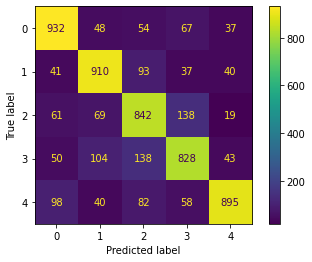

In [ ]:
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(ytest, y_pred)
plot_confusion_matrix(rf_pl.fit(Xtrain, ytrain),X=Xtest, y_true=ytest)

In [ ]:
FP = confusion.sum(axis=0) - np.diag(confusion)  
FN = confusion.sum(axis=1) - np.diag(confusion)
TP = np.diag(confusion)
TN = confusion.sum() - (FP + FN + TP)

-> Acurácia: nos diz quantos acertos o nosso modelo teve

In [ ]:
for c in range(0, 5):
  print("CLASSE: ", c,"ACURÁCIA: ", (TP[c] + TN[c]) / float(TP[c] + TN[c] + FP[c] + FN[c])) # Acurácia

CLASSE:  0 ACURÁCIA:  0.9208595387840671
CLASSE:  1 ACURÁCIA:  0.9173654786862334
CLASSE:  2 ACURÁCIA:  0.8836477987421384
CLASSE:  3 ACURÁCIA:  0.8869671558350803
CLASSE:  4 ACURÁCIA:  0.9271488469601677


-> Sensibilidade: Essa métrica avalia a capacidade do método de detectar com sucesso resultados classificados como positivos. Ela pode ser obtida pela equação:

In [ ]:
for c in range(0, 5):
  print("CLASSE: ", c,"SENSIBILIDADE:", (TP[c] / float(TP[c] + FN[c]))) # Sensibilidade (ou recall)

CLASSE:  0 SENSIBILIDADE: 0.8172231985940246
CLASSE:  1 SENSIBILIDADE: 0.8144513826940232
CLASSE:  2 SENSIBILIDADE: 0.7617360496014172
CLASSE:  3 SENSIBILIDADE: 0.7016337059329321
CLASSE:  4 SENSIBILIDADE: 0.7476555839727195


-> Especificidade: avalia a capacidade do método de detectar resultados negativos. Podemos calculá-la usando a equação:

In [ ]:
for c in range(0, 5):
  print("CLASSE: ", c,"ESPECIFICIDADE: ", (TN[c] / float(TN[c] + FP[c]))) # Especificidade

CLASSE:  0 ESPECIFICIDADE:  0.9465765372873964
CLASSE:  1 ESPECIFICIDADE:  0.9424288507495112
CLASSE:  2 ESPECIFICIDADE:  0.913601741022851
CLASSE:  3 ESPECIFICIDADE:  0.934224950668713
CLASSE:  4 ESPECIFICIDADE:  0.973412436827071


-> Taxa de falsos positivos



In [ ]:
for c in range(0, 5):
  print("CLASSE: ", c,"TAXA FP: ", (FP[c] / float(TN[c] + FP[c]))) #Taxa Positiva Falsa

CLASSE:  0 TAXA FP:  0.05342346271260358
CLASSE:  1 TAXA FP:  0.05757114925048881
CLASSE:  2 TAXA FP:  0.08639825897714908
CLASSE:  3 TAXA FP:  0.065775049331287
CLASSE:  4 TAXA FP:  0.026587563172929027


# -> PRECISÃO: Podemos definir a precisão de um modelo de Machine Learning como a proporção de predições corretas de uma categoria em relação a todas as previsões feitas dessa categoria. 

In [ ]:
for c in range(0, 5):
  print("CLASSE: ", c,"PRECISÃO: ", (TP[c] / float(TP[c] + FP[c]))) # Precisão

CLASSE:  0 PRECISÃO:  0.7914893617021277
CLASSE:  1 PRECISÃO:  0.7750424448217318
CLASSE:  2 PRECISÃO:  0.6841686555290374
CLASSE:  3 PRECISÃO:  0.7311827956989247
CLASSE:  4 PRECISÃO:  0.8787575150300602


### CONCLUSÃO
-> Em um primeiro momento, podemos achar que uma acurácia abaixo dos 80% é algo muito ruim para um modelo de predição. Porém, observem que estamos tratando de uma modelagem de comportamento humano (algo extremamente complexo).

-> Com a sensibilidade, podemos notar que o nosso modelo é eficiente para classificar casos em que o motorista aceita o cupom.

-> Em suma, este trabalho serviu para entendermos como, usando dados de uma pesquisa realizada em centenas de indivíduos, podemos utilizar regras simples baseadas em contexto individual de uma forma extremamente útil para gerar modelos que solucionam problemas de previsão de comportamento desse indivíduo.